# Image Classification

-----

## Fruits and vegetables image classifications 

2024-07-15 02:14:57.645762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 02:15:08.744631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 3115 files belonging to 36 classes.


2024-07-15 02:15:44.540848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:38:00.0, compute capability: 8.9
2024-07-15 02:15:44.542421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20763 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:3a:00.0, compute capability: 8.9
2024-07-15 02:15:44.543732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 20763 MB memory:  -> device: 2, name: NVIDIA L4, pci bus id: 0000:3c:00.0, compute capability: 8.9
2024-07-15 02:15:44.545176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 20763 MB memory:  -> device: 3, name: NVIDIA L4, pci bus id: 0000:3e:00.0, compute capability: 8.9


Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


2024-07-15 02:15:53.464034: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:15:53.616467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:15:53.714871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:15:54.081195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:15:54.752765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


Num GPUs Available:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-07-15 02:15:55.247019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of devices: 4
Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


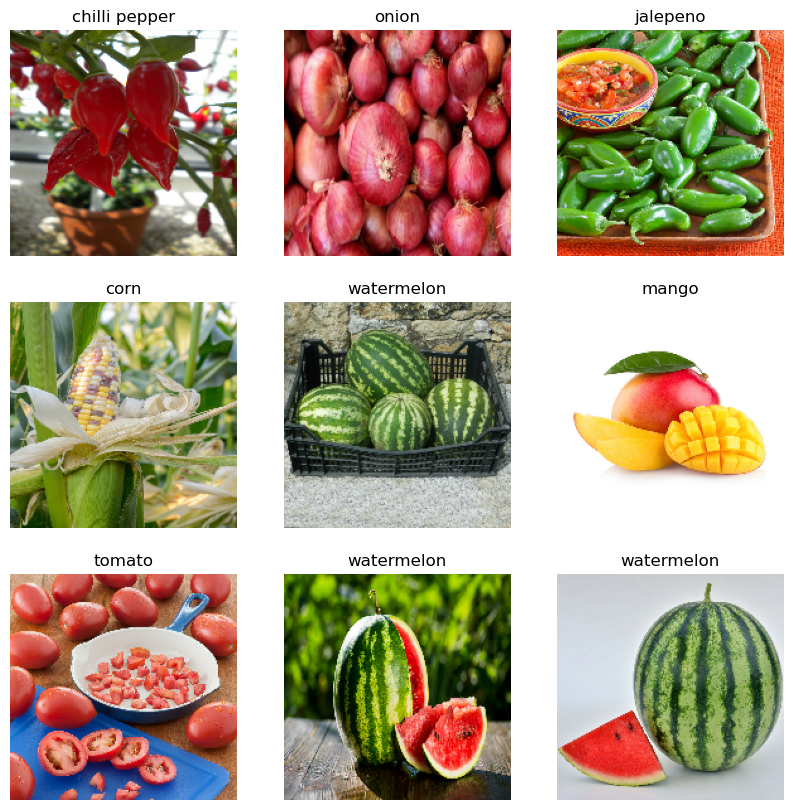

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np

data_train_path ="dataset/fruit-and-vegetable-image-recognition/train"
data_test_path="dataset/fruit-and-vegetable-image-recognition/test"
data_val_path = "dataset/fruit-and-vegetable-image-recognition/validation"

img_width = 180
img_height = 180

data_train = tf.keras.utils.image_dataset_from_directory(
data_train_path,
    shuffle= True,
    image_size= (img_width, img_height),
    batch_size = 32,
    validation_split=False
)

data_cat = data_train.class_names

data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width,img_height),
    batch_size=32,
    shuffle=False,
    validation_split=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_width,img_height),
    batch_size=32,
    shuffle=False,
    validation_split=False
)

plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
        

data_train

import tensorflow as tf

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Define batch size
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Load and preprocess data
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=GLOBAL_BATCH_SIZE,
    validation_split=False
)

data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width, img_height),
    batch_size=GLOBAL_BATCH_SIZE,
    shuffle=False,
    validation_split=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_width, img_height),
    batch_size=GLOBAL_BATCH_SIZE,
    shuffle=False,
    validation_split=False
)

# Define the model within the strategy scope
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(data_cat))
    ])
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])



In [3]:
import time

# Start the timer
start_time = time.time()

# Train the model
epochs = 25
history = model.fit(data_train, validation_data=data_val,epochs=epochs,batch_size=32,verbose=1 )

# End the timer
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time

total_time

Epoch 1/25


2024-07-15 02:29:29.732359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.067588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.284834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.349409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.495634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.557142: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:30.654029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:31.101576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:31.102442: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:05 - loss: 0.0675 - accuracy: 0.9922

2024-07-15 02:29:31.879622: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:31.880296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0542 - accuracy: 0.9896

2024-07-15 02:29:32.271832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:32.384311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0503 - accuracy: 0.9883

2024-07-15 02:29:32.554873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:32.718225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0510 - accuracy: 0.9877

2024-07-15 02:29:33.547746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0459 - accuracy: 0.9893

2024-07-15 02:29:33.891989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/25 [===========>..................] - ETA: 4s - loss: 0.0416 - accuracy: 0.9906

2024-07-15 02:29:34.436009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:34.437064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0366 - accuracy: 0.9915

2024-07-15 02:29:34.983613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0327 - accuracy: 0.9927

2024-07-15 02:29:36.351816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0474 - accuracy: 0.9912

2024-07-15 02:29:36.976101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:36.976160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:36.976309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:36.976358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:36.976392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 276ms/step - loss: 0.0469 - accuracy: 0.9913 - val_loss: 0.3137 - val_accuracy: 0.9516


2024-07-15 02:29:38.413498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:38.413564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:38.413596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:38.413632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:38.413648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 2/25


2024-07-15 02:29:39.262073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:39.616061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:39.833197: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:39.899658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:40.043141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:40.089509: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:40.203840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:40.652092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:40.652521: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0844 - accuracy: 0.9844

2024-07-15 02:29:41.466103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:41.467163: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0864 - accuracy: 0.9870

2024-07-15 02:29:41.861864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:41.976492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.1215 - accuracy: 0.9844

2024-07-15 02:29:42.170472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:42.321540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0858 - accuracy: 0.9844

2024-07-15 02:29:43.186428: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0864 - accuracy: 0.9844

2024-07-15 02:29:43.539655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 5s - loss: 0.0784 - accuracy: 0.9861

2024-07-15 02:29:44.096840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:44.097739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 4s - loss: 0.0640 - accuracy: 0.9889

2024-07-15 02:29:44.622460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0593 - accuracy: 0.9901

2024-07-15 02:29:46.013609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0547 - accuracy: 0.9901

2024-07-15 02:29:46.629359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:46.629435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:46.629494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:46.629517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:46.629561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 283ms/step - loss: 0.0551 - accuracy: 0.9904 - val_loss: 0.2899 - val_accuracy: 0.9544


2024-07-15 02:29:48.170967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:48.171046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:48.171066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:48.171099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:48.171227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 3/25


2024-07-15 02:29:49.020015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.356177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.573760: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.637365: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.763665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.822935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:49.931102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:50.377564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:50.378140: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0105 - accuracy: 1.0000

2024-07-15 02:29:51.211814: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:51.212893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0217 - accuracy: 0.9922

2024-07-15 02:29:51.629678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:51.744453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0199 - accuracy: 0.9922

2024-07-15 02:29:51.931264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:52.078495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0198 - accuracy: 0.9944

2024-07-15 02:29:52.936874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0191 - accuracy: 0.9941

2024-07-15 02:29:53.289858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 5s - loss: 0.0330 - accuracy: 0.9905

2024-07-15 02:29:53.843541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:53.845879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 4s - loss: 0.0463 - accuracy: 0.9896

2024-07-15 02:29:54.388117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0477 - accuracy: 0.9891

2024-07-15 02:29:55.800807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9896

2024-07-15 02:29:56.431900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:56.431948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:56.431979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:56.432009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:56.432038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 10s 282ms/step - loss: 0.0534 - accuracy: 0.9897 - val_loss: 0.2409 - val_accuracy: 0.9487


2024-07-15 02:29:57.895715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:57.895844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:57.896258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:29:57.896341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:29:57.896420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 4/25


2024-07-15 02:29:58.750208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.083210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.287207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.363435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.494530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.575673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:29:59.662531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:00.111028: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:00.111619: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:05 - loss: 0.0082 - accuracy: 1.0000

2024-07-15 02:30:00.921139: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:00.922381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0169 - accuracy: 0.9948

2024-07-15 02:30:01.307417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:01.419793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0329 - accuracy: 0.9941

2024-07-15 02:30:01.577830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:01.724280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0330 - accuracy: 0.9933

2024-07-15 02:30:02.574261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0385 - accuracy: 0.9912

2024-07-15 02:30:02.915972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0360 - accuracy: 0.9913

2024-07-15 02:30:03.445980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:03.447796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0367 - accuracy: 0.9915

2024-07-15 02:30:04.008381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0349 - accuracy: 0.9917

2024-07-15 02:30:05.367454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0429 - accuracy: 0.9899

2024-07-15 02:30:05.972089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:05.972163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:05.972187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:05.972218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:05.972254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 288ms/step - loss: 0.0433 - accuracy: 0.9897 - val_loss: 0.2392 - val_accuracy: 0.9544


2024-07-15 02:30:07.756252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:07.756318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:07.756377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:07.756411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:07.756442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

Epoch 5/25


2024-07-15 02:30:08.584706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:08.939651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.150555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.252077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.376481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.442297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.536601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.983012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:09.983993: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 1.0000

2024-07-15 02:30:10.775304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:10.777287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0234 - accuracy: 0.9948

2024-07-15 02:30:11.172908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:11.300403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0192 - accuracy: 0.9961

2024-07-15 02:30:11.466934: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:11.613520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0205 - accuracy: 0.9967

2024-07-15 02:30:12.462112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0285 - accuracy: 0.9951

2024-07-15 02:30:12.814929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/25 [===========>..................] - ETA: 4s - loss: 0.0319 - accuracy: 0.9945

2024-07-15 02:30:13.374232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:13.374850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0433 - accuracy: 0.9915

2024-07-15 02:30:13.904761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0412 - accuracy: 0.9922

2024-07-15 02:30:15.276982: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9907

2024-07-15 02:30:15.906937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:15.907005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:15.907048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:15.907061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:15.907109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 276ms/step - loss: 0.0455 - accuracy: 0.9907 - val_loss: 0.2211 - val_accuracy: 0.9630


2024-07-15 02:30:17.341955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:17.342020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:17.342059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:17.342101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:17.342135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 6/25


2024-07-15 02:30:18.180691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:18.528782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:18.742810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:18.829557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:18.961818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:19.026628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:19.132088: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:19.580659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:19.581203: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0103 - accuracy: 1.0000

2024-07-15 02:30:20.379987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:20.381027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0339 - accuracy: 0.9922

2024-07-15 02:30:20.773469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:20.905225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0379 - accuracy: 0.9922

2024-07-15 02:30:21.079228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:21.230317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0333 - accuracy: 0.9922

2024-07-15 02:30:22.067125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0349 - accuracy: 0.9912

2024-07-15 02:30:22.427585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0342 - accuracy: 0.9905

2024-07-15 02:30:22.979723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:22.981521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0445 - accuracy: 0.9915

2024-07-15 02:30:23.502164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0467 - accuracy: 0.9922

2024-07-15 02:30:24.899443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9900

2024-07-15 02:30:25.527898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:25.527957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:25.527979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:25.527997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:25.528040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 284ms/step - loss: 0.0514 - accuracy: 0.9900 - val_loss: 0.2386 - val_accuracy: 0.9573


2024-07-15 02:30:27.120784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:27.120845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:27.120881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:27.120912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:27.120959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 7/25


2024-07-15 02:30:27.968188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.307100: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.534505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.599925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.731607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.798589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:28.891741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:29.338932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:29.339775: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0151 - accuracy: 1.0000

2024-07-15 02:30:30.147247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:30.149605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0218 - accuracy: 0.9974

2024-07-15 02:30:30.567458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:30.674586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0300 - accuracy: 0.9961

2024-07-15 02:30:30.843488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:30.990030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0311 - accuracy: 0.9944

2024-07-15 02:30:31.832451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0278 - accuracy: 0.9951

2024-07-15 02:30:32.179700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0363 - accuracy: 0.9939

2024-07-15 02:30:32.726726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:32.729109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0401 - accuracy: 0.9928

2024-07-15 02:30:33.266645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0370 - accuracy: 0.9927

2024-07-15 02:30:34.628698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0431 - accuracy: 0.9915

2024-07-15 02:30:35.236011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:35.236080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:35.236225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:35.236283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:35.236314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 275ms/step - loss: 0.0449 - accuracy: 0.9907 - val_loss: 0.2246 - val_accuracy: 0.9516


2024-07-15 02:30:36.657812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:36.657906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:36.658311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:36.658386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:36.658517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 8/25


2024-07-15 02:30:37.512740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:37.849910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.066097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.148595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.274126: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.333413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.432181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.881713: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:38.882428: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0256 - accuracy: 0.9922

2024-07-15 02:30:39.704625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:39.706827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0234 - accuracy: 0.9896

2024-07-15 02:30:40.080924: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:40.212046: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0264 - accuracy: 0.9883

2024-07-15 02:30:40.372500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:40.518968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0195 - accuracy: 0.9933

2024-07-15 02:30:41.387083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0352 - accuracy: 0.9912

2024-07-15 02:30:41.745241: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0497 - accuracy: 0.9878

2024-07-15 02:30:42.288729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:42.290309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0484 - accuracy: 0.9876

2024-07-15 02:30:42.817685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0405 - accuracy: 0.9901

2024-07-15 02:30:44.181493: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9883

2024-07-15 02:30:44.804322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:44.804372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:44.804419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:44.804442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:44.804507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 10s 281ms/step - loss: 0.0502 - accuracy: 0.9884 - val_loss: 0.2231 - val_accuracy: 0.9601


2024-07-15 02:30:46.370585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:46.370647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:46.370974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:46.371030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:46.371080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 9/25


2024-07-15 02:30:47.192352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:47.544203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:47.758623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:47.856144: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:47.981053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:48.042055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:48.140940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:48.593187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:48.593748: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:05 - loss: 0.0366 - accuracy: 0.9844

2024-07-15 02:30:49.396365: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:49.397345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0346 - accuracy: 0.9870

2024-07-15 02:30:49.793208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:49.909504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0484 - accuracy: 0.9863

2024-07-15 02:30:50.067311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:50.215181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0377 - accuracy: 0.9900

2024-07-15 02:30:51.068786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0338 - accuracy: 0.9912

2024-07-15 02:30:51.417338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0420 - accuracy: 0.9905

2024-07-15 02:30:51.984368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:51.986293: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0371 - accuracy: 0.9902

2024-07-15 02:30:52.509720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0332 - accuracy: 0.9911

2024-07-15 02:30:53.927377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9907

2024-07-15 02:30:54.531646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:54.531712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:54.531861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:54.531906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:54.531952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 277ms/step - loss: 0.0365 - accuracy: 0.9907 - val_loss: 0.2288 - val_accuracy: 0.9544


2024-07-15 02:30:55.958678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:55.958759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:30:55.958981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:55.959007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:30:55.959030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 10/25


2024-07-15 02:30:56.779947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.144969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.353937: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.443381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.568784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.650863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:57.738875: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:58.186240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:58.186486: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0102 - accuracy: 1.0000

2024-07-15 02:30:59.008323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:59.009424: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0140 - accuracy: 0.9974

2024-07-15 02:30:59.397127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:59.509774: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0132 - accuracy: 0.9980

2024-07-15 02:30:59.696254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:30:59.851721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0354 - accuracy: 0.9944

2024-07-15 02:31:00.699387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0368 - accuracy: 0.9941

2024-07-15 02:31:01.046506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0357 - accuracy: 0.9948

2024-07-15 02:31:01.592821: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:01.594606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0316 - accuracy: 0.9948

2024-07-15 02:31:02.127616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0309 - accuracy: 0.9953

2024-07-15 02:31:03.507043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0360 - accuracy: 0.9929

2024-07-15 02:31:04.133898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:04.133944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:04.133982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:04.134026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:04.134055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 282ms/step - loss: 0.0360 - accuracy: 0.9929 - val_loss: 0.2981 - val_accuracy: 0.9573


2024-07-15 02:31:05.691493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:05.691555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:05.691660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:05.691691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:05.691766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 11/25


2024-07-15 02:31:06.565105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:06.895819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.126446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.201451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.339117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.403074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.496520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.946753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:07.947806: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:07 - loss: 0.0114 - accuracy: 1.0000

2024-07-15 02:31:08.756159: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:08.756962: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0306 - accuracy: 0.9974

2024-07-15 02:31:09.158673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:09.264117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0283 - accuracy: 0.9961

2024-07-15 02:31:09.430946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:09.577822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0570 - accuracy: 0.9911

2024-07-15 02:31:10.410597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0509 - accuracy: 0.9922

2024-07-15 02:31:10.756112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0465 - accuracy: 0.9931

2024-07-15 02:31:11.280889: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:11.283446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0530 - accuracy: 0.9902

2024-07-15 02:31:11.831498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0455 - accuracy: 0.9917

2024-07-15 02:31:13.194515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9917

2024-07-15 02:31:13.809575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:13.809625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:13.809669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:13.809686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:13.809720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 274ms/step - loss: 0.0461 - accuracy: 0.9917 - val_loss: 0.2298 - val_accuracy: 0.9573


2024-07-15 02:31:15.261280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:15.261348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:15.261495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:15.261552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:15.261610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 12/25


2024-07-15 02:31:16.132281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:16.459542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:16.663932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:16.757908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:16.898920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:16.957310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:17.076706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:17.524878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:17.525675: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:07 - loss: 0.0250 - accuracy: 0.9922

2024-07-15 02:31:18.341526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:18.342828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0262 - accuracy: 0.9948

2024-07-15 02:31:18.715229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:18.836034: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0414 - accuracy: 0.9902

2024-07-15 02:31:19.014680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:19.162824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0523 - accuracy: 0.9877

2024-07-15 02:31:20.009619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0474 - accuracy: 0.9893

2024-07-15 02:31:20.350364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0657 - accuracy: 0.9887

2024-07-15 02:31:20.910842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:20.914419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0543 - accuracy: 0.9902

2024-07-15 02:31:21.430325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0469 - accuracy: 0.9917

2024-07-15 02:31:22.804090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9908

2024-07-15 02:31:23.411487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:23.411544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:23.411582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:23.411619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:23.411663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 275ms/step - loss: 0.0559 - accuracy: 0.9907 - val_loss: 0.2673 - val_accuracy: 0.9658


2024-07-15 02:31:24.853720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:24.853790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:24.853963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:24.854001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:24.854019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 13/25


2024-07-15 02:31:25.816521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.169809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.388973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.461145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.592093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.663079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:26.754512: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:27.206346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:27.207186: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0134 - accuracy: 0.9922

2024-07-15 02:31:28.023547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:28.026421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0385 - accuracy: 0.9922

2024-07-15 02:31:28.412766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:28.535013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0359 - accuracy: 0.9922

2024-07-15 02:31:28.700430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:28.867612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0312 - accuracy: 0.9933

2024-07-15 02:31:29.717244: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0320 - accuracy: 0.9932

2024-07-15 02:31:30.061105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0376 - accuracy: 0.9922

2024-07-15 02:31:30.635062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:30.636834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 4s - loss: 0.0313 - accuracy: 0.9935

2024-07-15 02:31:31.177408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0442 - accuracy: 0.9932

2024-07-15 02:31:32.561246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9920

2024-07-15 02:31:33.164987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:33.165056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:33.165118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:33.165132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:33.165152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 277ms/step - loss: 0.0400 - accuracy: 0.9920 - val_loss: 0.2081 - val_accuracy: 0.9630


2024-07-15 02:31:34.582738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:34.582823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:34.582850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:34.582897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:34.582978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 14/25


2024-07-15 02:31:35.432601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:35.784182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:35.995905: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.088833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.227974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.274504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.388448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.838457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:36.838909: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0174 - accuracy: 0.9922

2024-07-15 02:31:37.621305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:37.622870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0159 - accuracy: 0.9948

2024-07-15 02:31:37.997979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:38.118109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0219 - accuracy: 0.9941

2024-07-15 02:31:38.281927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:38.431101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0262 - accuracy: 0.9933

2024-07-15 02:31:39.263528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0247 - accuracy: 0.9941

2024-07-15 02:31:39.618925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0238 - accuracy: 0.9939

2024-07-15 02:31:40.156524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:40.157343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0561 - accuracy: 0.9909

2024-07-15 02:31:40.703111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0541 - accuracy: 0.9911

2024-07-15 02:31:42.054739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9900

2024-07-15 02:31:42.687248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:42.687304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:42.687348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:42.687384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:42.687435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 274ms/step - loss: 0.0518 - accuracy: 0.9900 - val_loss: 0.2141 - val_accuracy: 0.9516


2024-07-15 02:31:44.115918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:44.115992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:44.116173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:44.116208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:44.116348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 15/25


2024-07-15 02:31:45.071812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:45.428184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:45.639303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:45.735963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:45.872172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:45.941349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:46.033221: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:46.481920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:46.482298: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0152 - accuracy: 0.9922

2024-07-15 02:31:47.294375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:47.295698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0239 - accuracy: 0.9896

2024-07-15 02:31:47.698109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:47.814433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0202 - accuracy: 0.9922

2024-07-15 02:31:47.979730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:48.131935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0258 - accuracy: 0.9922

2024-07-15 02:31:49.008002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0311 - accuracy: 0.9902

2024-07-15 02:31:49.356899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 5s - loss: 0.0294 - accuracy: 0.9905

2024-07-15 02:31:49.911985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:49.912796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0470 - accuracy: 0.9896

2024-07-15 02:31:50.439730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0445 - accuracy: 0.9901

2024-07-15 02:31:51.790958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9906

2024-07-15 02:31:52.413982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:52.414037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:52.414093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:52.414140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:52.414169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 276ms/step - loss: 0.0404 - accuracy: 0.9907 - val_loss: 0.2340 - val_accuracy: 0.9630


2024-07-15 02:31:53.840854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:53.840914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:53.840995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:31:53.841029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:31:53.841117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 16/25


2024-07-15 02:31:54.706085: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.047702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.268895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.331763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.459154: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.522209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:55.628478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:56.078472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:56.079116: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0159 - accuracy: 1.0000

2024-07-15 02:31:56.914672: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:56.916671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0389 - accuracy: 0.9922

2024-07-15 02:31:57.289351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:57.406472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0303 - accuracy: 0.9941

2024-07-15 02:31:57.570387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:57.718216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0285 - accuracy: 0.9922

2024-07-15 02:31:58.558092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0316 - accuracy: 0.9912

2024-07-15 02:31:58.901643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/25 [===========>..................] - ETA: 4s - loss: 0.0305 - accuracy: 0.9914

2024-07-15 02:31:59.451632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:31:59.453174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0341 - accuracy: 0.9909

2024-07-15 02:31:59.985919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0342 - accuracy: 0.9911

2024-07-15 02:32:01.372425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9902

2024-07-15 02:32:02.001777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:02.001885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:02.001920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:02.001979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:02.002057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 276ms/step - loss: 0.0404 - accuracy: 0.9904 - val_loss: 0.2418 - val_accuracy: 0.9544


2024-07-15 02:32:03.423217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:03.423266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:03.423290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:03.423349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:03.423382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 17/25


2024-07-15 02:32:04.294407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:04.626346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:04.836930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:04.913653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:05.042218: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:05.105721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:05.204477: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:05.651677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:05.652491: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0291 - accuracy: 0.9844

2024-07-15 02:32:06.462464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:06.463516: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0216 - accuracy: 0.9922

2024-07-15 02:32:06.853834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:06.983478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0183 - accuracy: 0.9941

2024-07-15 02:32:07.141871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:07.291045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0200 - accuracy: 0.9933

2024-07-15 02:32:08.123045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0197 - accuracy: 0.9932

2024-07-15 02:32:08.467824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0242 - accuracy: 0.9913

2024-07-15 02:32:09.019148: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:09.020263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0240 - accuracy: 0.9922

2024-07-15 02:32:09.553311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0290 - accuracy: 0.9922

2024-07-15 02:32:10.974765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0419 - accuracy: 0.9905

2024-07-15 02:32:11.581646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:11.581734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:11.581784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:11.581825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:11.581862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 282ms/step - loss: 0.0414 - accuracy: 0.9904 - val_loss: 0.2209 - val_accuracy: 0.9573


2024-07-15 02:32:13.139654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:13.139715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:13.139750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:13.139806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:13.139844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

Epoch 18/25


2024-07-15 02:32:14.020437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.348024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.564178: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.658023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.792242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.850385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:14.955246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:15.405930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:15.406424: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:07 - loss: 0.0423 - accuracy: 0.9844

2024-07-15 02:32:16.213063: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:16.213925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0312 - accuracy: 0.9896

2024-07-15 02:32:16.610255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:16.723386: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0254 - accuracy: 0.9922

2024-07-15 02:32:16.891823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:17.038719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0241 - accuracy: 0.9922

2024-07-15 02:32:17.886494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0338 - accuracy: 0.9922

2024-07-15 02:32:18.240360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0354 - accuracy: 0.9913

2024-07-15 02:32:18.770957: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:18.772626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0320 - accuracy: 0.9922

2024-07-15 02:32:19.297908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0375 - accuracy: 0.9911

2024-07-15 02:32:20.696326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/25 [==========================>...] - ETA: 0s - loss: 0.0382 - accuracy: 0.9918

2024-07-15 02:32:21.316327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:21.316398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:21.316455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:21.316495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:21.316549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 277ms/step - loss: 0.0374 - accuracy: 0.9920 - val_loss: 0.2299 - val_accuracy: 0.9544


2024-07-15 02:32:22.775047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:22.775123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:22.775344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:22.775385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:22.775501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 19/25


2024-07-15 02:32:23.597362: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:23.971470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.175254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.262509: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.387547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.454539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.548732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.997947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:24.998822: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0231 - accuracy: 0.9922

2024-07-15 02:32:25.799010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:25.800282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0143 - accuracy: 0.9974

2024-07-15 02:32:26.204553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:26.314127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0169 - accuracy: 0.9961

2024-07-15 02:32:26.498068: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:26.644352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0175 - accuracy: 0.9967

2024-07-15 02:32:27.481803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0219 - accuracy: 0.9961

2024-07-15 02:32:27.822491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0241 - accuracy: 0.9957

2024-07-15 02:32:28.361447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:28.363096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0304 - accuracy: 0.9935

2024-07-15 02:32:28.895423: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0326 - accuracy: 0.9932

2024-07-15 02:32:30.270358: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9917

2024-07-15 02:32:30.900208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:30.900261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:30.900323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:30.900345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:30.900387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 281ms/step - loss: 0.0404 - accuracy: 0.9917 - val_loss: 0.2526 - val_accuracy: 0.9573


2024-07-15 02:32:32.470970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:32.471042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:32.471086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:32.471133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:32.471202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 20/25


2024-07-15 02:32:33.300880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:33.656540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:33.873613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:33.959812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:34.086881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:34.166304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:34.247605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:34.700212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:34.700507: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0204 - accuracy: 0.9922

2024-07-15 02:32:35.530993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:35.532353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0173 - accuracy: 0.9948

2024-07-15 02:32:35.924209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:36.033198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0146 - accuracy: 0.9961

2024-07-15 02:32:36.213288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:36.360381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0249 - accuracy: 0.9944

2024-07-15 02:32:37.209021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0285 - accuracy: 0.9941

2024-07-15 02:32:37.565292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0295 - accuracy: 0.9939

2024-07-15 02:32:38.112988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:38.115665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0409 - accuracy: 0.9902

2024-07-15 02:32:38.650563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0354 - accuracy: 0.9911

2024-07-15 02:32:40.043188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0399 - accuracy: 0.9902

2024-07-15 02:32:40.663115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:40.663165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:40.663224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:40.663251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:40.663287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 277ms/step - loss: 0.0395 - accuracy: 0.9904 - val_loss: 0.2415 - val_accuracy: 0.9573


2024-07-15 02:32:42.086867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:42.086938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:42.086982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:42.087099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:42.087122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 21/25


2024-07-15 02:32:42.965823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.300788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.504274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.587449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.718762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.796061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:43.891885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:44.338865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:44.339370: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 1.0000

2024-07-15 02:32:45.154925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:45.156165: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0178 - accuracy: 0.9948

2024-07-15 02:32:45.550967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:45.679348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0202 - accuracy: 0.9941

2024-07-15 02:32:45.827885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:45.991240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0220 - accuracy: 0.9922

2024-07-15 02:32:46.847534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0212 - accuracy: 0.9922

2024-07-15 02:32:47.191946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0232 - accuracy: 0.9913

2024-07-15 02:32:47.740171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:47.742085: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0403 - accuracy: 0.9909

2024-07-15 02:32:48.293003: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0363 - accuracy: 0.9917

2024-07-15 02:32:49.658147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0353 - accuracy: 0.9912

2024-07-15 02:32:50.286863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:50.286918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:50.286961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:50.286993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:50.287055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 9s 277ms/step - loss: 0.0348 - accuracy: 0.9913 - val_loss: 0.2157 - val_accuracy: 0.9601


2024-07-15 02:32:51.726439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:51.726499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:51.726537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:32:51.726583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:32:51.726610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 22/25


2024-07-15 02:32:52.702725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.055203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.260724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.359915: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.491594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.544577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:53.656826: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:54.109745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:54.110436: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:07 - loss: 0.0034 - accuracy: 1.0000

2024-07-15 02:32:54.969213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:54.970517: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0223 - accuracy: 0.9922

2024-07-15 02:32:55.350749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:55.463568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0177 - accuracy: 0.9941

2024-07-15 02:32:55.637329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:55.783345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0153 - accuracy: 0.9944

2024-07-15 02:32:56.640903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0166 - accuracy: 0.9941

2024-07-15 02:32:56.989167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0158 - accuracy: 0.9948

2024-07-15 02:32:57.546446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:32:57.548563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0276 - accuracy: 0.9928

2024-07-15 02:32:58.090647: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0273 - accuracy: 0.9932

2024-07-15 02:32:59.449308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9904

2024-07-15 02:33:00.084245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:00.084317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:00.084342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:00.084381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:00.084401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 285ms/step - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.2187 - val_accuracy: 0.9601


2024-07-15 02:33:01.729084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:01.729165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:01.729186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:01.729241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:01.729266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 23/25


2024-07-15 02:33:02.557962: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:02.912466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.138475: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.202357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.327794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.397252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.496423: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.941985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:03.942289: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:05 - loss: 0.0054 - accuracy: 1.0000

2024-07-15 02:33:04.727141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:04.728556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0308 - accuracy: 0.9870

2024-07-15 02:33:05.113890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:05.233468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 4s - loss: 0.0317 - accuracy: 0.9883

2024-07-15 02:33:05.399366: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:05.563734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0315 - accuracy: 0.9888

2024-07-15 02:33:06.399001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0301 - accuracy: 0.9893

2024-07-15 02:33:06.748415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/25 [===========>..................] - ETA: 4s - loss: 0.0278 - accuracy: 0.9898

2024-07-15 02:33:07.306409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:07.307870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0439 - accuracy: 0.9889

2024-07-15 02:33:07.856095: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0378 - accuracy: 0.9896

2024-07-15 02:33:09.235287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9897

2024-07-15 02:33:09.880021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:09.880083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:09.880138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:09.880198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:09.880243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

25/25 [==============================] - 10s 283ms/step - loss: 0.0392 - accuracy: 0.9897 - val_loss: 0.2379 - val_accuracy: 0.9573


2024-07-15 02:33:11.437832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:11.437942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:11.437998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:11.438062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:11.438087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

Epoch 24/25


2024-07-15 02:33:12.281060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:12.649057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:12.862412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:12.957750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:13.083284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:13.144980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:13.243412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:13.691186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:13.691999: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:07 - loss: 0.0102 - accuracy: 1.0000

2024-07-15 02:33:14.515168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:14.516641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0134 - accuracy: 0.9974

2024-07-15 02:33:14.917695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:15.043188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0176 - accuracy: 0.9941

2024-07-15 02:33:15.189421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:15.346997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0221 - accuracy: 0.9922

2024-07-15 02:33:16.200981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0218 - accuracy: 0.9922

2024-07-15 02:33:16.545225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 4s - loss: 0.0305 - accuracy: 0.9913

2024-07-15 02:33:17.107699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:17.108193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 3s - loss: 0.0296 - accuracy: 0.9928

2024-07-15 02:33:17.667083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0343 - accuracy: 0.9901

2024-07-15 02:33:19.005757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/25 [===========================>..] - ETA: 0s - loss: 0.0401 - accuracy: 0.9906

2024-07-15 02:33:19.663887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:19.663960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:19.664043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:19.664088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:19.664118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

25/25 [==============================] - 9s 278ms/step - loss: 0.0396 - accuracy: 0.9907 - val_loss: 0.2448 - val_accuracy: 0.9601


2024-07-15 02:33:21.097571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:21.097637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:21.097700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:21.097747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:21.097811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

Epoch 25/25


2024-07-15 02:33:21.933299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.284305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.499841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.598815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.725333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.785978: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:22.892397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:23.340678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:23.341667: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/25 [>.............................] - ETA: 1:06 - loss: 0.0562 - accuracy: 0.9922

2024-07-15 02:33:24.143274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:24.146057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/25 [==>...........................] - ETA: 5s - loss: 0.0222 - accuracy: 0.9974

2024-07-15 02:33:24.565593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:24.675414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/25 [===>..........................] - ETA: 5s - loss: 0.0248 - accuracy: 0.9961

2024-07-15 02:33:24.870694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:25.025728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/25 [=======>......................] - ETA: 5s - loss: 0.0233 - accuracy: 0.9933

2024-07-15 02:33:25.908867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/25 [========>.....................] - ETA: 5s - loss: 0.0237 - accuracy: 0.9922

2024-07-15 02:33:26.259521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/25 [=========>....................] - ETA: 5s - loss: 0.0220 - accuracy: 0.9931

2024-07-15 02:33:26.800161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-07-15 02:33:26.800721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/25 [=============>................] - ETA: 4s - loss: 0.0224 - accuracy: 0.9922

2024-07-15 02:33:27.336734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/25 [=================>............] - ETA: 3s - loss: 0.0227 - accuracy: 0.9927

2024-07-15 02:33:28.696938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9917

2024-07-15 02:33:29.332569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:29.332646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-15 02:33:29.332711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:29.332758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:29.332810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

25/25 [==============================] - 10s 285ms/step - loss: 0.0311 - accuracy: 0.9917 - val_loss: 0.2219 - val_accuracy: 0.9630


2024-07-15 02:33:30.911830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:30.911904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:30.911932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:30.912003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-15 02:33:30.912079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

242.23089814186096

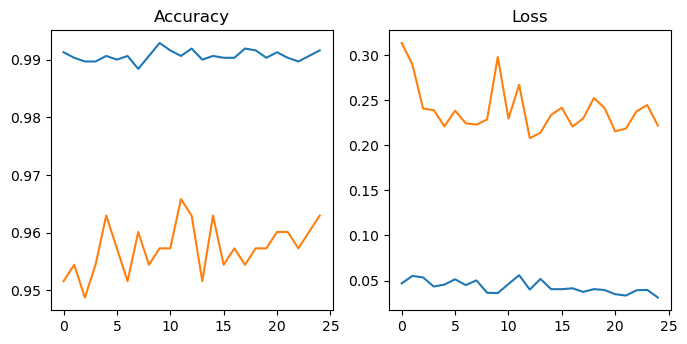

In [4]:
epochs_range = range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(epochs_range, history.history['accuracy'],label='Training Accuracy')
plt.plot(epochs_range , history.history['val_accuracy'],label ='Validation Accuracy')
plt.title('Accuracy')
plt.subplot(2,2,2)
plt.plot(epochs_range , history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.show()

In [5]:
import pandas as pd

# Extract data from history
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Create DataFrame
df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Train Accuracy': train_acc,
    'Validation Loss': val_loss,
    'Validation Accuracy': val_acc
})

# Round float values to 4 decimal places
df = df.round(4)

# Display the table
print(df.to_string(index=False))

 Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
     1      0.0469          0.9913           0.3137               0.9516
     2      0.0551          0.9904           0.2899               0.9544
     3      0.0534          0.9897           0.2409               0.9487
     4      0.0433          0.9897           0.2392               0.9544
     5      0.0455          0.9907           0.2211               0.9630
     6      0.0514          0.9900           0.2386               0.9573
     7      0.0449          0.9907           0.2246               0.9516
     8      0.0502          0.9884           0.2231               0.9601
     9      0.0365          0.9907           0.2288               0.9544
    10      0.0360          0.9929           0.2981               0.9573
    11      0.0461          0.9917           0.2298               0.9573
    12      0.0559          0.9907           0.2673               0.9658
    13      0.0400          0.9920           0.2081

In [8]:
# Save as CSV
df.to_csv('training_history.csv', index=False)


In [10]:
data = pd.read_csv('training_history.csv')

# Display the head and tail of the dataframe
head_data = data.head()
tail_data = data.tail()

(head_data, tail_data)

(   Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
 0      1      0.0469          0.9913           0.3137               0.9516
 1      2      0.0551          0.9904           0.2899               0.9544
 2      3      0.0534          0.9897           0.2409               0.9487
 3      4      0.0433          0.9897           0.2392               0.9544
 4      5      0.0455          0.9907           0.2211               0.9630,
     Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
 20     21      0.0348          0.9913           0.2157               0.9601
 21     22      0.0333          0.9904           0.2187               0.9601
 22     23      0.0392          0.9897           0.2379               0.9573
 23     24      0.0396          0.9907           0.2448               0.9601
 24     25      0.0311          0.9917           0.2219               0.9630)

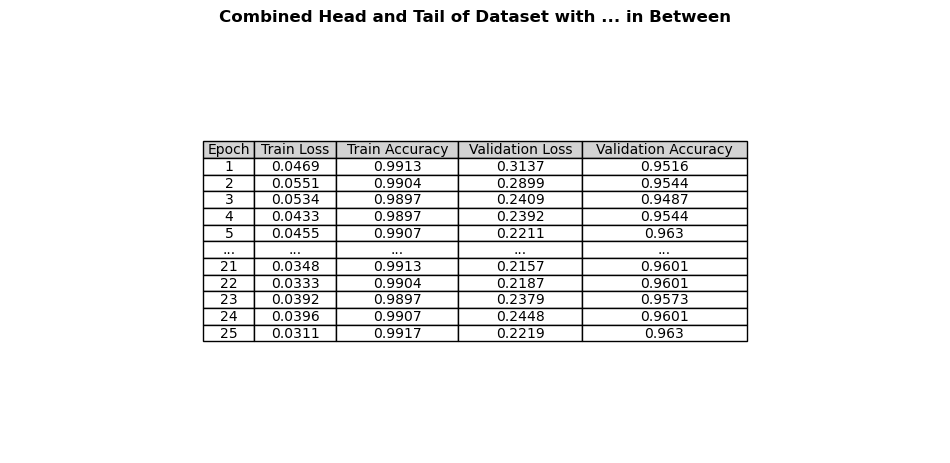

In [12]:
combined_data = pd.concat([head_data, pd.DataFrame([["..."] * len(data.columns)], columns=data.columns), tail_data])

# Display the combined data with style
import matplotlib.pyplot as plt

# Define a function to create a table with styles
def styled_table(dataframe, title):
    fig, ax = plt.subplots(figsize=(12, len(dataframe) / 2))
    ax.axis('off')
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=["lightgrey"] * dataframe.shape[1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))
    ax.set_title(title, fontweight="bold")
    plt.show()

styled_table(combined_data, 'Combined Head and Tail of Dataset with ... in Between')

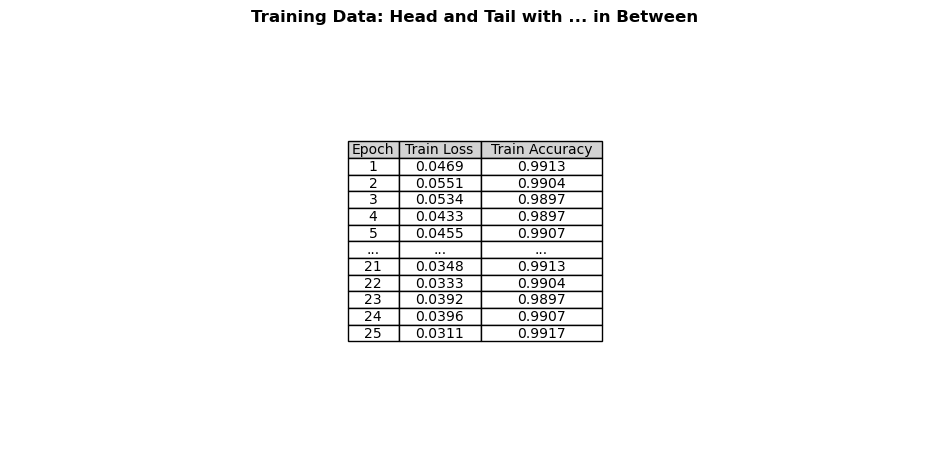

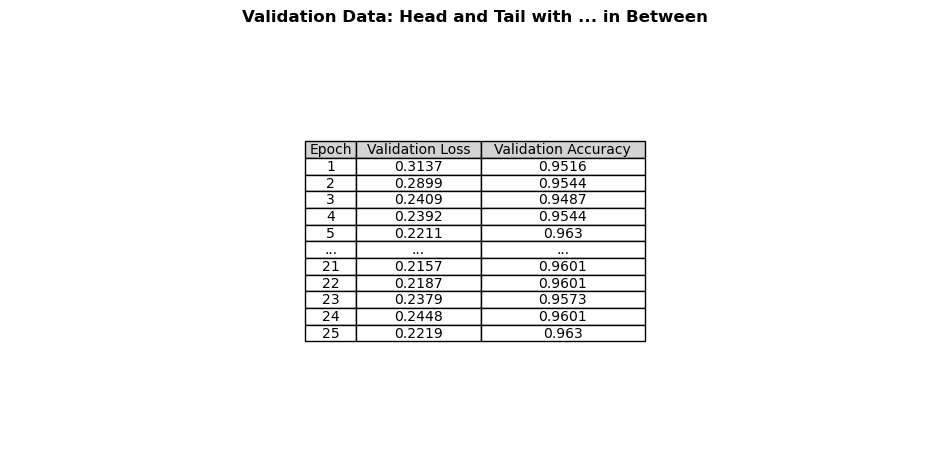

In [13]:
# Split the combined data into training and validation parts
train_data = combined_data[['Epoch', 'Train Loss', 'Train Accuracy']]
validation_data = combined_data[['Epoch', 'Validation Loss', 'Validation Accuracy']]

# Display the training data
styled_table(train_data, 'Training Data: Head and Tail with ... in Between')

# Display the validation data
styled_table(validation_data, 'Validation Data: Head and Tail with ... in Between')

In [6]:
# Define image dimensions
img_width, img_height = 180, 180  # Change as per your model's requirements

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load image
    image = tf.keras.utils.load_img(image_path, target_size=(img_width, img_height))
    # Convert image to array
    img_arr = tf.keras.utils.img_to_array(image)
    # Expand dimensions to match the input shape of the model
    img_bat = tf.expand_dims(img_arr, 0)
    return img_bat

In [7]:
# Function to classify the image
def classify_image(model, image_path):
    # Load and preprocess the image
    img_bat = load_and_preprocess_image(image_path)
    # Predict the class of the image
    predictions = model.predict(img_bat)
    return predictions

In [8]:
# Enter your fruit image to classify
image_path = 'dataset/fruit-and-vegetable-image-recognition/validation/apple/Image_1.jpg'

# Classify the image
predictions = classify_image(model, image_path)


# Get the predicted class and accuracy
predicted_class_index = np.argmax(predictions[0])
predicted_class = data_cat[predicted_class_index]
accuracy = predictions[0][predicted_class_index] * 100

# Print the result
print('Veg / Fruit in Image is {} with accuracy of {:.2f}%'.format(predicted_class, accuracy))

1/1 [==============================] - 1s 813ms/step
Veg / Fruit in Image is apple with accuracy of 2830.55%
